# Image Classification PROJECT - CAR DAMAGE PREDICTION

### Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import time
import optuna
import matplotlib.pyplot as plt


e:\Project Car Damage  Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Load Data

In [ ]:
# Apply transformation

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(contrast=0.25, brightness= 0.25, saturation= 0.25),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [ ]:
dataset_path = './final_dataset'
dataset = datasets.ImageFolder(root= dataset_path, transform= image_transform)

In [ ]:
len(dataset)

2300

In [ ]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [ ]:
num_classes = len(dataset.classes)
num_classes

6

### Train/test Split

In [ ]:
train_size = int(0.75*len(dataset))
test_size = len(dataset) - train_size


In [ ]:
train_size, test_size

(1725, 575)

In [ ]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(1725, 575)

### Dataloader

In [ ]:
Batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle= False)

In [ ]:
for images, labels in train_loader:
    print(labels.shape)
    print(images.shape)
    break

torch.Size([32])
torch.Size([32, 3, 224, 224])


In [ ]:
images[0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


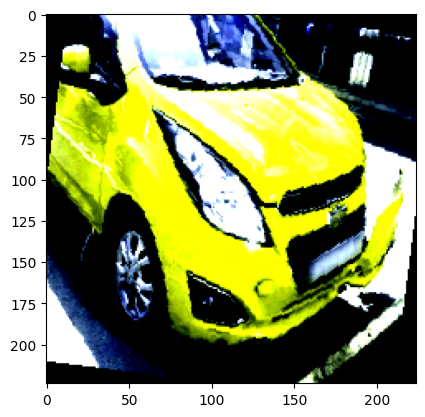

In [ ]:
plt.imshow(images[1].permute((1, 2, 0)))
plt.show()

### Visualise data

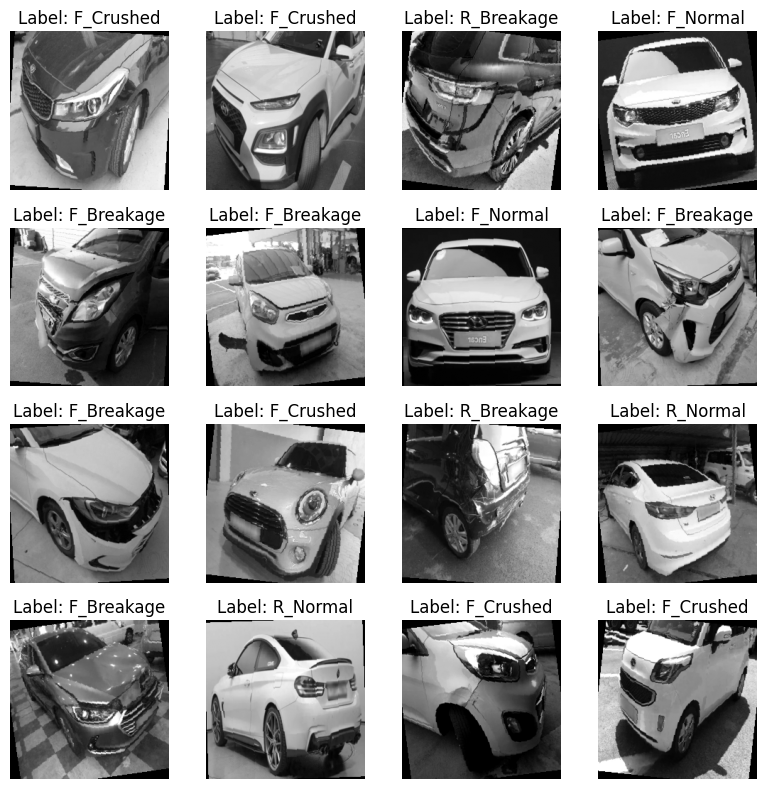

In [ ]:


images, labels = next(iter(train_loader))


fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0].numpy(), cmap='gray')  # Display image
    ax.set_title(f"Label: {class_names[labels[i].item()]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Model 1 : CNN

In [ ]:
class car_classifier_cnn(nn.Module): 
    def __init__(self, num_classes):  
        super().__init__() #
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=1, padding=1), # in: (3, 224, 224) out: (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2), # in: (16, 224, 224) out: (16, 112, 112)
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1), # in: (16, 112, 112) out: (32, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2), # in: (32, 112, 112) out: (32, 56, 56)
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1), # in: (32, 56, 56) out: (64, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2), # in: (64, 56, 56) out: (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
model_cnn = car_classifier_cnn(num_classes= num_classes).to(device)
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr = 0.001)

In [ ]:
54*32

1728

In [ ]:
def train_model(model, criterion, optimizer, epochs = 5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            #forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Backward pass
            loss.backward()
            # optimization, update the weights
            optimizer.step()

            if (batch_num + 1) % 10 == 0:
                print(f'Batch:{batch_num+1}, Epoch :{epoch+1}, Loss: {loss.item():0.2f}')

            running_loss += loss.item() # loss is a tensor when multiply .item() you will get regular numbers
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Avg loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        total = 0
        correct = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1) # find the max from output and 1 is for dimension 1. _, means max value and predicted means predicted class or index of that max value
                total += labels.size(0)
                correct += (predicted == labels).sum().item() #.sum() counts the number of correct predictions and .item() converts the tensor to a Python scalar (integer) to be added to correct.
                all_labels.extend(labels.cpu().numpy()) # .extend is for add array and concatinate array and move to cpu because this are regular python list
                all_predictions.extend(predicted.cpu().numpy())

            print(f'validation accuracy: {100 * correct / total:.2f}%')
    
    end = time.time()
    print(f'Excecution time:{end - start} seconds')
    
    return all_labels, all_predictions

In [ ]:
#example
# _, predicted = torch.max(outputs.data, 1) # find the max from output and _, means max value and predicted means predicted class

values, indices = torch.max(torch.tensor([[10, 15, 12, 6, 11]]), 1)
values, indices # value is the max value and indices is index of max value taht is your class

(tensor([15]), tensor([1]))

In [ ]:
all_labels, all_predictions = train_model(model_cnn, criterion_cnn, optimizer_cnn, epochs = 5)

Batch:10, Epoch :1, Loss: 1.77
Batch:20, Epoch :1, Loss: 1.79
Batch:30, Epoch :1, Loss: 1.77
Batch:40, Epoch :1, Loss: 1.66
Batch:50, Epoch :1, Loss: 1.52
Epoch 1/5, Avg loss: 1.8442
validation accuracy: 44.70%
Batch:10, Epoch :2, Loss: 1.33
Batch:20, Epoch :2, Loss: 1.46
Batch:30, Epoch :2, Loss: 1.17
Batch:40, Epoch :2, Loss: 1.49
Batch:50, Epoch :2, Loss: 1.11
Epoch 2/5, Avg loss: 1.3207
validation accuracy: 50.26%
Batch:10, Epoch :3, Loss: 1.11
Batch:20, Epoch :3, Loss: 1.18
Batch:30, Epoch :3, Loss: 1.32
Batch:40, Epoch :3, Loss: 1.23
Batch:50, Epoch :3, Loss: 0.90
Epoch 3/5, Avg loss: 1.1579
validation accuracy: 53.91%
Batch:10, Epoch :4, Loss: 1.55
Batch:20, Epoch :4, Loss: 1.06
Batch:30, Epoch :4, Loss: 1.17
Batch:40, Epoch :4, Loss: 1.10
Batch:50, Epoch :4, Loss: 1.06
Epoch 4/5, Avg loss: 1.0364
validation accuracy: 54.96%
Batch:10, Epoch :5, Loss: 0.94
Batch:20, Epoch :5, Loss: 1.00
Batch:30, Epoch :5, Loss: 0.83
Batch:40, Epoch :5, Loss: 0.95
Batch:50, Epoch :5, Loss: 0.99
E

### Model 2 : Optimized CNN: Regularization Techniques for Overfitting Prevention

In [ ]:
class car_classifier_with_Regularization(nn.Module): 
    def __init__(self, num_classes):  
        super().__init__() 
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=1, padding=1), # in: (3, 224, 224) out: (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2), # in: (16, 224, 224) out: (16, 112, 112)
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1), # in: (16, 112, 112) out: (32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2), # in: (32, 112, 112) out: (32, 56, 56)
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1), # in: (32, 56, 56) out: (64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2), # in: (64, 56, 56) out: (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
model_Regularization = car_classifier_with_Regularization(num_classes= num_classes).to(device)
criterion_Regularization = nn.CrossEntropyLoss()
optimizer_Regularization = optim.Adam(model_Regularization.parameters(), lr = 0.001, weight_decay=0.004)

In [ ]:
all_labels, all_predictions = train_model(model_Regularization, criterion_Regularization, optimizer_Regularization, epochs = 5)

Batch:10, Epoch :1, Loss: 10.27
Batch:20, Epoch :1, Loss: 5.85
Batch:30, Epoch :1, Loss: 2.25
Batch:40, Epoch :1, Loss: 1.69
Batch:50, Epoch :1, Loss: 1.46
Epoch 1/5, Avg loss: 7.0171
validation accuracy: 47.48%
Batch:10, Epoch :2, Loss: 1.14
Batch:20, Epoch :2, Loss: 1.08
Batch:30, Epoch :2, Loss: 1.20
Batch:40, Epoch :2, Loss: 1.43
Batch:50, Epoch :2, Loss: 1.35
Epoch 2/5, Avg loss: 1.3532
validation accuracy: 50.61%
Batch:10, Epoch :3, Loss: 1.13
Batch:20, Epoch :3, Loss: 1.49
Batch:30, Epoch :3, Loss: 1.06
Batch:40, Epoch :3, Loss: 1.31
Batch:50, Epoch :3, Loss: 1.25
Epoch 3/5, Avg loss: 1.2939
validation accuracy: 50.78%
Batch:10, Epoch :4, Loss: 1.65
Batch:20, Epoch :4, Loss: 1.26
Batch:30, Epoch :4, Loss: 1.24
Batch:40, Epoch :4, Loss: 1.11
Batch:50, Epoch :4, Loss: 1.22
Epoch 4/5, Avg loss: 1.2362
validation accuracy: 48.52%
Batch:10, Epoch :5, Loss: 1.06
Batch:20, Epoch :5, Loss: 1.13
Batch:30, Epoch :5, Loss: 1.18
Batch:40, Epoch :5, Loss: 1.13
Batch:50, Epoch :5, Loss: 1.10


### Model 3 : Transfer learning with Efficientnet 

In [ ]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [ ]:
class car_classifier_efficientnet(nn.Module): #our class car_classifier is derived fron nn.module
    def __init__(self, num_classes):  #init method which takes self as an input
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)

        )
    
    def forward(self, x):
        return self.model(x)
         

In [ ]:
model_efficient = car_classifier_efficientnet(num_classes= num_classes).to(device)
criterion_efficient = nn.CrossEntropyLoss()
optimizer_efficient = optim.Adam(model_efficient.parameters(), lr = 0.001)

all_labels, all_predictions = train_model(model_efficient, criterion_efficient, optimizer_efficient, epochs = 5)

Batch:10, Epoch :1, Loss: 0.84
Batch:20, Epoch :1, Loss: 0.92
Batch:30, Epoch :1, Loss: 0.79
Batch:40, Epoch :1, Loss: 0.94
Batch:50, Epoch :1, Loss: 0.85
Epoch 1/5, Avg loss: 0.9801
validation accuracy: 71.65%
Batch:10, Epoch :2, Loss: 0.61
Batch:20, Epoch :2, Loss: 0.70
Batch:30, Epoch :2, Loss: 0.74
Batch:40, Epoch :2, Loss: 0.69
Batch:50, Epoch :2, Loss: 0.54
Epoch 2/5, Avg loss: 0.6206
validation accuracy: 79.65%
Batch:10, Epoch :3, Loss: 0.41
Batch:20, Epoch :3, Loss: 0.54
Batch:30, Epoch :3, Loss: 0.56
Batch:40, Epoch :3, Loss: 0.58
Batch:50, Epoch :3, Loss: 0.46
Epoch 3/5, Avg loss: 0.5298
validation accuracy: 76.52%
Batch:10, Epoch :4, Loss: 0.19
Batch:20, Epoch :4, Loss: 0.67
Batch:30, Epoch :4, Loss: 0.26
Batch:40, Epoch :4, Loss: 0.50
Batch:50, Epoch :4, Loss: 0.30
Epoch 4/5, Avg loss: 0.4241
validation accuracy: 77.74%
Batch:10, Epoch :5, Loss: 0.46
Batch:20, Epoch :5, Loss: 0.26
Batch:30, Epoch :5, Loss: 0.19
Batch:40, Epoch :5, Loss: 0.36
Batch:50, Epoch :5, Loss: 0.45
E

### Model 4 : Transfer learning with Resnet

In [ ]:
model = models.resnet18(weights='DEFAULT')
in_features = model.fc.in_features
in_features

512

In [ ]:
class car_classifier_resnet(nn.Module): #our class car_classifier is derived fron nn.module
    def __init__(self, num_classes):  #init method which takes self as an input
        super().__init__()
        self.model_res = models.resnet18(weights='DEFAULT')

        in_features = self.model_res.fc.in_features

        self.model_res.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)

        )
    
    def forward(self, x):
        return self.model_res(x)

In [ ]:
model_res = car_classifier_resnet(num_classes= num_classes).to(device)
criterion_res = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(model_res.parameters(), lr = 0.001)

all_labels, all_predictions = train_model(model_res, criterion_res, optimizer_res, epochs = 5)

Batch:10, Epoch :1, Loss: 1.66
Batch:20, Epoch :1, Loss: 1.17
Batch:30, Epoch :1, Loss: 1.16
Batch:40, Epoch :1, Loss: 1.06
Batch:50, Epoch :1, Loss: 0.78
Epoch 1/5, Avg loss: 1.1731
validation accuracy: 48.00%
Batch:10, Epoch :2, Loss: 1.04
Batch:20, Epoch :2, Loss: 0.79
Batch:30, Epoch :2, Loss: 0.68
Batch:40, Epoch :2, Loss: 0.75
Batch:50, Epoch :2, Loss: 0.84
Epoch 2/5, Avg loss: 0.8354
validation accuracy: 74.61%
Batch:10, Epoch :3, Loss: 0.61
Batch:20, Epoch :3, Loss: 0.87
Batch:30, Epoch :3, Loss: 0.80
Batch:40, Epoch :3, Loss: 0.70
Batch:50, Epoch :3, Loss: 0.64
Epoch 3/5, Avg loss: 0.7274
validation accuracy: 74.09%
Batch:10, Epoch :4, Loss: 0.71
Batch:20, Epoch :4, Loss: 0.72
Batch:30, Epoch :4, Loss: 0.49
Batch:40, Epoch :4, Loss: 0.57
Batch:50, Epoch :4, Loss: 0.68
Epoch 4/5, Avg loss: 0.6323
validation accuracy: 68.70%
Batch:10, Epoch :5, Loss: 0.47
Batch:20, Epoch :5, Loss: 0.39
Batch:30, Epoch :5, Loss: 0.81
Batch:40, Epoch :5, Loss: 0.65
Batch:50, Epoch :5, Loss: 0.23
E

### Model 5:  Fine-Tuned ResNet: Last Layer Unfrozen for Optimized Classification

In [ ]:
class car_classifier_resnet(nn.Module): 
    def __init__(self, num_classes):  
        super().__init__()
        self.model_res = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model_res.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model_res.layer4.parameters():
            param.requires_grad = True  

        in_features = self.model_res.fc.in_features

        self.model_res.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)

        )
    
    def forward(self, x):
        return self.model_res(x)

In [ ]:
model_res = car_classifier_resnet(num_classes= num_classes).to(device)
criterion_res = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(model_res.parameters(), lr = 0.001)

all_labels, all_predictions = train_model(model_res, criterion_res, optimizer_res, epochs = 10)

Batch:10, Epoch :1, Loss: 0.97
Batch:20, Epoch :1, Loss: 0.92
Batch:30, Epoch :1, Loss: 0.70
Batch:40, Epoch :1, Loss: 0.64
Batch:50, Epoch :1, Loss: 0.33
Epoch 1/10, Avg loss: 0.9176
validation accuracy: 70.96%
Batch:10, Epoch :2, Loss: 0.46
Batch:20, Epoch :2, Loss: 0.47
Batch:30, Epoch :2, Loss: 0.52
Batch:40, Epoch :2, Loss: 0.35
Batch:50, Epoch :2, Loss: 0.59
Epoch 2/10, Avg loss: 0.5171
validation accuracy: 72.70%
Batch:10, Epoch :3, Loss: 0.28
Batch:20, Epoch :3, Loss: 0.39
Batch:30, Epoch :3, Loss: 0.41
Batch:40, Epoch :3, Loss: 0.26
Batch:50, Epoch :3, Loss: 0.42
Epoch 3/10, Avg loss: 0.4058
validation accuracy: 77.04%
Batch:10, Epoch :4, Loss: 0.22
Batch:20, Epoch :4, Loss: 0.13
Batch:30, Epoch :4, Loss: 0.31
Batch:40, Epoch :4, Loss: 0.24
Batch:50, Epoch :4, Loss: 0.23
Epoch 4/10, Avg loss: 0.3083
validation accuracy: 76.00%
Batch:10, Epoch :5, Loss: 0.20
Batch:20, Epoch :5, Loss: 0.16
Batch:30, Epoch :5, Loss: 0.31
Batch:40, Epoch :5, Loss: 0.70
Batch:50, Epoch :5, Loss: 0.

### ResNet-50 Optimization: Hyperparameter Search for Enhanced Accuracy

In [ ]:


def objective(trial):

    
    # hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.6,  log=True)
    decay_rate = trial.suggest_float("weight_decay", 1e-5, 1e-2,  log=True)
    # epochs = trial.suggest_int('epochs', 1, 10)

    # DataLoader: assuming train_dataset is defined globally
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # For validation, here we use a separate test_loader.
    # If you need to split train_dataset into train/val, do so accordingly.
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Create model using the hyperparameters (input shape is defined in SimpleCNN via dummy_input)
    model = car_classifier_resnet(num_classes= num_classes, dropout_rate = dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=decay_rate)

    # Training loop
    start = time.time()

    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    end = time.time()
    print(f'Excecution time:{end - start} seconds')
    
    # Report accuracy to Optuna; we maximize accuracy here.
    return accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Display best trial's results
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.2f}%")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-02-22 19:54:41,546] A new study created in memory with name: no-name-67a192b8-8ce3-4014-a895-3fe01cb8d1b7
[I 2025-02-22 19:58:49,945] Trial 0 finished with value: 76.34782608695652 and parameters: {'learning_rate': 0.0026700327044978196, 'batch_size': 18, 'dropout_rate': 0.22070282892061008, 'weight_decay': 0.0009175130290449664}. Best is trial 0 with value: 76.34782608695652.


Excecution time:247.29300904273987 seconds


[I 2025-02-22 20:11:16,533] Trial 1 finished with value: 69.21739130434783 and parameters: {'learning_rate': 0.023194128955106207, 'batch_size': 63, 'dropout_rate': 0.10312246528435912, 'weight_decay': 0.00012222355497263582}. Best is trial 0 with value: 76.34782608695652.


Excecution time:745.7915389537811 seconds


[I 2025-02-22 20:18:17,345] Trial 2 finished with value: 59.82608695652174 and parameters: {'learning_rate': 0.018348246197442908, 'batch_size': 23, 'dropout_rate': 0.4120443390882439, 'weight_decay': 0.0017583652288027404}. Best is trial 0 with value: 76.34782608695652.


Excecution time:420.0016300678253 seconds


[I 2025-02-22 20:33:55,374] Trial 3 finished with value: 76.69565217391305 and parameters: {'learning_rate': 0.0026706032438269488, 'batch_size': 54, 'dropout_rate': 0.13526874002884123, 'weight_decay': 0.00011913398905378749}. Best is trial 3 with value: 76.69565217391305.


Excecution time:937.2120478153229 seconds


[I 2025-02-22 20:40:55,903] Trial 4 finished with value: 76.0 and parameters: {'learning_rate': 0.003236792769564631, 'batch_size': 21, 'dropout_rate': 0.3250413906275491, 'weight_decay': 0.00016976546024498394}. Best is trial 3 with value: 76.69565217391305.


Excecution time:419.814888715744 seconds


[I 2025-02-22 20:49:18,802] Trial 5 finished with value: 76.34782608695652 and parameters: {'learning_rate': 0.001998118783939497, 'batch_size': 27, 'dropout_rate': 0.12054357417366944, 'weight_decay': 0.0008192543943009075}. Best is trial 3 with value: 76.69565217391305.


Excecution time:502.07264494895935 seconds


[I 2025-02-22 21:02:56,753] Trial 6 finished with value: 52.52173913043478 and parameters: {'learning_rate': 0.016507577331615727, 'batch_size': 41, 'dropout_rate': 0.17927201656849287, 'weight_decay': 5.147250554294586e-05}. Best is trial 3 with value: 76.69565217391305.


Excecution time:817.0878355503082 seconds


[I 2025-02-22 21:18:27,207] Trial 7 finished with value: 65.3913043478261 and parameters: {'learning_rate': 0.0354299209944487, 'batch_size': 55, 'dropout_rate': 0.43074588638693717, 'weight_decay': 7.68368584400253e-05}. Best is trial 3 with value: 76.69565217391305.


Excecution time:929.5385172367096 seconds


[I 2025-02-22 21:26:40,470] Trial 8 finished with value: 75.82608695652173 and parameters: {'learning_rate': 0.008982656411383095, 'batch_size': 27, 'dropout_rate': 0.10961339939798971, 'weight_decay': 4.2155584711008085e-05}. Best is trial 3 with value: 76.69565217391305.


Excecution time:492.36486411094666 seconds


[I 2025-02-22 21:40:27,526] Trial 9 finished with value: 60.34782608695652 and parameters: {'learning_rate': 0.025833136889390172, 'batch_size': 37, 'dropout_rate': 0.15824702769205962, 'weight_decay': 0.0003907818664987427}. Best is trial 3 with value: 76.69565217391305.


Excecution time:826.2514431476593 seconds
Best trial:
  Accuracy: 76.70%
  Best hyperparameters:
    learning_rate: 0.0026706032438269488
    batch_size: 54
    dropout_rate: 0.13526874002884123
    weight_decay: 0.00011913398905378749


In [ ]:
all_labels[:5], all_predictions[:5]

([np.int64(3), np.int64(1), np.int64(3), np.int64(2), np.int64(0)],
 [np.int64(3), np.int64(1), np.int64(3), np.int64(2), np.int64(0)])

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)


              precision    recall  f1-score   support

           0       0.88      0.83      0.85       143
           1       0.70      0.81      0.75       103
           2       0.91      0.85      0.88       125
           3       0.88      0.79      0.83        73
           4       0.68      0.76      0.72        59
           5       0.81      0.82      0.81        72

    accuracy                           0.82       575
   macro avg       0.81      0.81      0.81       575
weighted avg       0.82      0.82      0.82       575



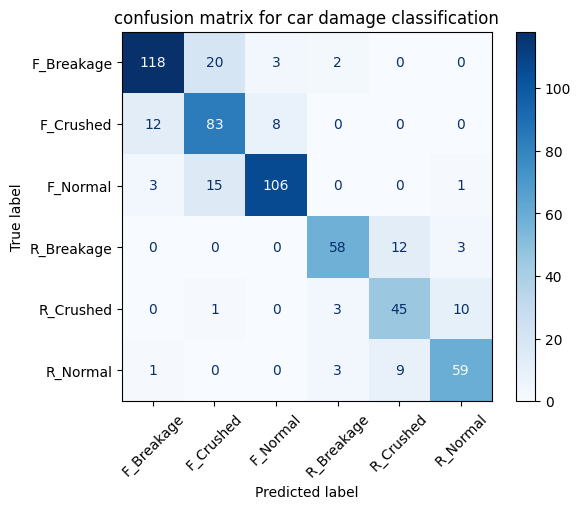

In [ ]:


import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_predictions, labels= np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('confusion matrix for car damage classification')
plt.show()

### Model 6 : EfficientNet with Transfer Learning: Frozen Backbone for Feature Extraction

In [ ]:
class car_classifier_efficientnet(nn.Module): #our class car_classifier is derived fron nn.module
    def __init__(self, num_classes):  #init method which takes self as an input
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        # freeze all the layers except Fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)

        )
    
    def forward(self, x):
        return self.model(x)

In [ ]:
model_efficient = car_classifier_efficientnet(num_classes= num_classes).to(device)
criterion_efficient = nn.CrossEntropyLoss()
optimizer_efficient = optim.Adam(filter(lambda p: p.requires_grad, model_efficient.parameters()), lr = 0.001)

all_labels, all_predictions = train_model(model_efficient, criterion_efficient, optimizer_efficient, epochs = 5)

Batch:10, Epoch :1, Loss: 1.74
Batch:20, Epoch :1, Loss: 1.56
Batch:30, Epoch :1, Loss: 1.37
Batch:40, Epoch :1, Loss: 1.32
Batch:50, Epoch :1, Loss: 1.52
Epoch 1/5, Avg loss: 1.4975
validation accuracy: 57.39%
Batch:10, Epoch :2, Loss: 1.17
Batch:20, Epoch :2, Loss: 1.13
Batch:30, Epoch :2, Loss: 1.31
Batch:40, Epoch :2, Loss: 1.19
Batch:50, Epoch :2, Loss: 1.12
Epoch 2/5, Avg loss: 1.1741
validation accuracy: 61.57%
Batch:10, Epoch :3, Loss: 1.06
Batch:20, Epoch :3, Loss: 1.11
Batch:30, Epoch :3, Loss: 0.89
Batch:40, Epoch :3, Loss: 1.04
Batch:50, Epoch :3, Loss: 1.09
Epoch 3/5, Avg loss: 1.0693
validation accuracy: 63.65%
Batch:10, Epoch :4, Loss: 1.03
Batch:20, Epoch :4, Loss: 0.99
Batch:30, Epoch :4, Loss: 1.27
Batch:40, Epoch :4, Loss: 0.93
Batch:50, Epoch :4, Loss: 0.96
Epoch 4/5, Avg loss: 1.0003
validation accuracy: 65.22%
Batch:10, Epoch :5, Loss: 1.17
Batch:20, Epoch :5, Loss: 1.10
Batch:30, Epoch :5, Loss: 0.99
Batch:40, Epoch :5, Loss: 0.96
Batch:50, Epoch :5, Loss: 0.96
E

### CNN Optimization: Finding the Best Hyperparameters for Performance Boost

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import optuna

# Example: assuming num_classes is defined elsewhere (e.g., num_classes = 2)
num_classes = 6

class SimpleCNN(nn.Module):
    def __init__(self, conv_layers, conv_filters, fc_layers, fc_units, num_classes=num_classes):
        """
        conv_layers: number of convolutional layers
        conv_filters: list of filters for each conv layer (length should match conv_layers)
        fc_layers: number of fully connected layers (excluding final classification layer)
        fc_units: list of units for each fc layer (length should match fc_layers)
        num_classes: number of output classes
        """
        super(SimpleCNN, self).__init__()
        layers = []
        in_channels = 3  # for RGB images

        # Create convolutional layers
        for i in range(conv_layers):
            out_channels = conv_filters[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)

        # Estimate the flattened dimension after conv layers (for 224x224 input)
        dummy_input = torch.zeros(1, 3, 224, 224)
        with torch.no_grad():
            conv_out = self.conv(dummy_input)
        flattened_size = conv_out.view(1, -1).size(1)

        # Create fully connected layers
        fc_layers_list = []
        in_features = flattened_size
        for j in range(fc_layers):
            out_features = fc_units[j]
            fc_layers_list.append(nn.Linear(in_features, out_features))
            fc_layers_list.append(nn.Dropout(dropout_rate))
            fc_layers_list.append(nn.ReLU())
            in_features = out_features

        # Final classification layer
        fc_layers_list.append(nn.Linear(in_features, num_classes))
        self.fc = nn.Sequential(*fc_layers_list)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def objective(trial):
    # Hyperparameters for convolutional part
    conv_layers = trial.suggest_int("conv_layers", 1, 5)
    conv_filters = []
    for i in range(conv_layers):
        conv_filters.append(trial.suggest_int(f"conv_filters_{i}", 16, 128, step=16))
    
    # Hyperparameters for fully connected part
    fc_layers = trial.suggest_int("fc_layers", 1, 5)
    fc_units = []
    for j in range(fc_layers):
        fc_units.append(trial.suggest_int(f"fc_units_{j}", 32, 512, step=32))
    
    # Other hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.6,  log=True)
    decay_rate = trial.suggest_float("weight_decay", 1e-5, 1e-2,  log=True)
    # epochs = trial.suggest_int('epochs', 1, 10)

    # DataLoader: assuming train_dataset is defined globally
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # For validation, here we use a separate test_loader.
    # If you need to split train_dataset into train/val, do so accordingly.
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Create model using the hyperparameters (input shape is defined in SimpleCNN via dummy_input)
    model = SimpleCNN(conv_layers, conv_filters, fc_layers, fc_units, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= decay_rate)

    # Training loop
    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    # Report accuracy to Optuna; we maximize accuracy here.
    return accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Display best trial's results
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.2f}%")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


### Model 6 : CNN after Hyperparameter

In [ ]:
Batch_size = 44
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle= True)
test_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle= False)

In [ ]:
class CNN_Hyperparmeter(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), #out (32, 224, 224)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out (32, 112, 112)
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out (32, 56, 56)
            nn.Flatten(),
            nn.Linear(32*56*56, 416),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(416, 384),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(384, 96),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(96, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
            
        )

    def forward(self, x):
        return self.network(x)
    

In [ ]:
model_6 = CNN_Hyperparmeter(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_6.parameters(), lr= 0.0011329271001979822, weight_decay=0.004)


In [ ]:
all_labels, all_predictions = train_model(model_6, criterion, optimizer, epochs = 5)

Batch:10, Epoch :1, Loss: 2.83
Batch:20, Epoch :1, Loss: 2.10
Batch:30, Epoch :1, Loss: 1.83
Batch:40, Epoch :1, Loss: 1.67
Epoch 1/5, Avg loss: 2.5673
validation accuracy: 18.84%
Batch:10, Epoch :2, Loss: 1.78
Batch:20, Epoch :2, Loss: 1.79
Batch:30, Epoch :2, Loss: 1.81
Batch:40, Epoch :2, Loss: 1.86
Epoch 2/5, Avg loss: 1.8080
validation accuracy: 21.80%
Batch:10, Epoch :3, Loss: 1.83
Batch:20, Epoch :3, Loss: 1.79
Batch:30, Epoch :3, Loss: 1.79
Batch:40, Epoch :3, Loss: 1.67
Epoch 3/5, Avg loss: 1.7829
validation accuracy: 30.49%
Batch:10, Epoch :4, Loss: 1.79
Batch:20, Epoch :4, Loss: 1.78
Batch:30, Epoch :4, Loss: 1.74
Batch:40, Epoch :4, Loss: 1.99
Epoch 4/5, Avg loss: 1.7813
validation accuracy: 30.67%
Batch:10, Epoch :5, Loss: 1.83
Batch:20, Epoch :5, Loss: 1.68
Batch:30, Epoch :5, Loss: 1.72
Batch:40, Epoch :5, Loss: 1.82
Epoch 5/5, Avg loss: 1.7648
validation accuracy: 32.12%
Excecution time:539.1014704704285 seconds
